In [1]:
from qiime2 import Artifact
from qiime2.plugins.fragment_insertion.methods import filter_features
from qiime2.plugins.emperor.actions import plot, biplot
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.diversity.actions import core_metrics_phylogenetic
from qiime2.plugins.fragment_insertion.methods import filter_features
from qiime2.plugins.diversity.visualizers import beta_group_significance
from qiime2.plugins.diversity.visualizers import alpha_group_significance
from qiime2.plugins.metadata.visualizers import tabulate
from qiime2.plugins.diversity.methods import alpha
from qiime2.plugins import taxa
from qiime2 import Artifact
import qiime2 as q2
import biom
import biom
import os
import pandas as pd
import glob
from qiime2.plugins import (feature_table,
fragment_insertion, 
feature_classifier, 
diversity, 
metadata, 
emperor, 
deicode, 
gneiss, 
taxa)
import pandas as pd

from qiime2 import Artifact

import seaborn as sns

import skbio
from skbio.stats.distance import MissingIDError
from skbio import DistanceMatrix

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import csv

import qiime2
from matplotlib.legend import Legend


/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [2]:
def check_and_create_dir(dir_name):
    CHECK_DIRECTORY = os.path.isdir(dir_name)
    if not CHECK_DIRECTORY:
        os.makedirs(dir_name)

# import data

### Remove blanks and katharo samples from biom table and metadata

In [17]:
# import metadata
mf = q2.Metadata.load('14385_20220208-102803.txt').to_dataframe()

# import table
bt = biom.load_table('141987_reference-hit.biom')
mf = mf.loc[bt.ids(), : ]

# directory for outputs (this will include things like figures and emperor plots)
inputs_dir_name = 'inputs'
check_and_create_dir(inputs_dir_name)
output_dir_name = 'plots-and-figures'
check_and_create_dir(output_dir_name)

In [20]:
mf.host_subject_id.unique()

array(['BLANK5.12D', 'BLANK.AssayAssure.20C.BLANK.1', 'BLANK5.12G',
       'BLANK5.12H', 'Katharo5.2speciesmock.1E.5thousand.prev',
       'BLANK.AssayAssure.20C.BLANK.2', 'BLANK.EtOH.20C.BLANK.2',
       'Katharo5.2speciesmock.1F.5hundred.new', 'BLANK.None.20C.BLANK.2',
       'BLANK.None.20C.BLANK.1', 'Katharo5.2speciesmock.1B.5million.prev',
       'Katharo5.2speciesmock.1F.5hundred.prev', 'BLANK5.12C',
       'Katharo5.2speciesmock.1G.50.new',
       'Katharo5.2speciesmock.1H.5.prev',
       'Katharo5.2speciesmock.1G.50.prev', 'Katharo5.Zymo.2F.5hundred',
       'BLANK.EtOH.20C.BLANK.1', 'Katharo5.Zymo.2G.50',
       'Katharo5.Zymo.2H.5', 'Katharo5.2speciesmock.1D.50thousand.new',
       'Katharo5.2speciesmock.1D.50thousand.prev', 'K',
       'Katharo5.2speciesmock.1E.5thousand.new', 'BLANK5.12E',
       'Katharo5.2speciesmock.1C.500thousand.new',
       'Katharo5.2speciesmock.1C.500thousand.prev',
       'Katharo5.Zymo.2C.500thousand', 'BLANK5.12F',
       'Katharo5.2speciesmock.1

In [4]:
# criteria to keep smaple  
keep = lambda sample: 'BLANK' not in sample and 'Katharo' not in sample

# identify the metadata data to keep (need to remove blank and kartho)
keep = [ind for ind in mf.index if keep(ind)]


#filter metadata
mf_filtered = mf.loc[keep, : ]

#filter biom table
bt_filter = bt.filter(mf_filtered.index, axis='sample')

#some features may have been removed that were unique to the samples removed
#now there may be a lot of 0's in our table, remove them and match tables
keep_feat = bt_filter.ids('observation')[bt_filter.sum(axis='observation') > 0]
bt_filter = bt_filter.filter(keep_feat, axis='observation')

In [22]:
mf_filtered.host_subject_id.unique()

array(['K', 'L', 'N', 'M', 'O', 'Q', 'P', 'S', 'R', 'T'], dtype=object)

### import table/tree/metadata into qiime2

In [5]:
#import tree
!qiime tools import \
  --input-path 141987_insertion_tree.relabelled.tre \
  --output-path rooted-tree.qza \
  --type 'Phylogeny[Rooted]'

#turn tables to q2 artifacts
q2mf_filtered = q2.Metadata(mf_filtered)
q2mf_filtered.save('filtered-metadata.qza')
q2bt = q2.Artifact.import_data('FeatureTable[Frequency]', bt_filter)
q2bt.save('filtered-table.qza')

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Imported 141987_insertion_tree.relabelled.tre as NewickDirectoryFormat to rooted-tree.qza


'filtered-table.qza'

### filter table to match tree

In [6]:
# #import filtered table and tree
# rooted_tree = q2.Artifact.load('rooted-tree.qza')

# #filter table to match tree
# tree_filtered_table, removed_table = filter_features(q2bt,rooted_tree)
# tree_filtered_table.save('tree-filtered-table.qza')

### TEMPORARY!!!!!

In [6]:
rooted_tree = q2.Artifact.load('rooted-tree.qza')

tree_filtered_table = q2.Artifact.load('tree-filtered-table.qza')

<visualization: Visualization uuid: 846262f3-0e13-4e20-b4ab-6c0b1bdcc612>

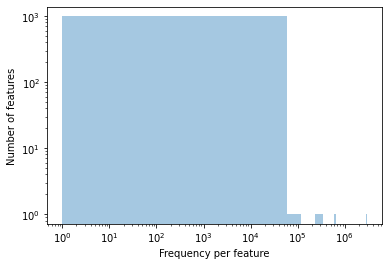

In [12]:
tbl = Artifact.load('tree-filtered-table.qza')
meta = qiime2.Metadata.load('filtered-metadata.qza')
# Singletons out
tbl_freq2 = tbl
feature_table.visualizers.summarize(tbl_freq2, meta).visualization

# Diversity

In [8]:
VAL_BASE_COL = 'validation_base_col'
VAL_BASE_VAL = 'base'
class MyDM(skbio.DistanceMatrix):
    def _stable_order(self, ids):

        id_order = sorted(self._id_index[i] for i in ids)
        return np.array(id_order, dtype=int)
    
    def between(self, from_, to_, allow_overlap=False):

        from_ = set(from_)
        to_ = set(to_)

        all_ids = from_ | to_
        not_present = all_ids - set(self._id_index)
        if not_present:
            raise MissingIDError("At least one ID (e.g., '%s') was not "
                                 "found." % not_present.pop())

        overlapping = from_ & to_
        if not allow_overlap and overlapping:
            raise KeyError("At least one ID overlaps in from_ and to_ "
                           "(e.g., '%s'). This constraint can removed with "
                           "allow_overlap=True." % overlapping.pop())

        return self._subset_to_dataframe(from_, to_)
    
    def _subset_to_dataframe(self, i_ids, j_ids):

        i_indices = self._stable_order(i_ids)
        j_indices = self._stable_order(j_ids)

        j_length = len(j_indices)
        j_labels = tuple([self.ids[j] for j in j_indices])

        i = []
        j = []

        values = [np.array([])]
        for i_idx in i_indices:
            i.extend([self.ids[i_idx]] * j_length)
            j.extend(j_labels)

            subset = self._data[i_idx, j_indices]
            values.append(subset)

        i = pd.Series(i, name='i')
        j = pd.Series(j, name='j')
        values = pd.Series(np.hstack(values), name='value')

        return pd.concat([i, j, values], axis=1)
    
def gather_between_distances(a_dm, a_md, col, id_col):
    pleasant_dm = MyDM(a_dm)

    tidy_data = []
    
    baseline_ids = {}
    for hid, grp in a_md.groupby(id_col):
        base_df = grp[grp[VAL_BASE_COL] == VAL_BASE_VAL]
        baseline_ids[hid] = base_df.index

    for (pres, hid), grp in a_md.groupby([col] + ['host_subject_id']):  
        if hid in baseline_ids:
            base_ids = baseline_ids[hid]
            distances = pleasant_dm.between(base_ids, grp.index, allow_overlap=True)

            distances['sample_preservation_method'] = pres
            distances['host_subject_id'] = hid
            distances['groupby'] = 'Distance to no preservative'
            tidy_data.append(distances)

    tidy_data = pd.concat(tidy_data)
    
    return tidy_data[tidy_data['i'] != tidy_data['j']]

def calc_inter_group(group_condition_i, group_condition_j, dist_mat, df, id_col):
    subjects = df[id_col].unique()
    already_proc = []
    pleasant_dm = MyDM(dist_mat)
    pairs = []
    for s in subjects:
        pairs.append(
             pleasant_dm.between(
#                 df.loc[df['host_subject_id'] == s].index,
#                 df.loc[~(df['host_subject_id'] == s) & ~(df['host_subject_id'].isin(already_proc))].index))
                df.loc[group_condition_i].index,
                df.loc[gropu_condition_j].index))
        already_proc.append(s)
    pd.concat(pairs).loc[:, 'value'].median()

def fancy_plotting(df, x, xlabel, y, ylabel, hue, legend_label, col, order=None, legend_text_map=None,
                   inter_distances=None):
    num_col = min(len(df[col].unique()), 3)
    g = sns.catplot(data=df, x=x, y=y, hue=hue, col=col, kind='box', col_wrap=num_col, order=order,)
#                     palette=sns.color_palette("RdBu_r", 7))
    
    g.set_axis_labels(xlabel, ylabel)
    g.set_xticklabels(order)
    g.set_titles("{col_name}")
    g._legend.set_title(legend_label)
    
    
    for t in g._legend.texts:
        t.set_text(legend_text_map[t._text])
    
    
    additional_legends = []
    additional_labels = []
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='xx-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
        for label, ls, value in inter_distances:
            additional_legends.append(
                ax.axhline(value, ls=ls, color='0.1', linewidth=2, label=label))
            additional_labels.append(label)
        # Create the second legend and add the artist manually.
        new_leg = Legend(g.fig, additional_legends, additional_labels,title='Reference distance')
    g.fig.add_artist(new_leg);
    return g

In [9]:
# permanova groups and other parameters
groups = ['host_subject_id', 'sample_preservation_method']
use_pairwise = True

def create_perma_groups(q2mat, q2meta, directory, groups, metric_used='unweighted_unifrac', use_pairwise=True):
    for group in groups:
        group_dir = os.path.join(directory, group)
        check_and_create_dir(group_dir)
        out_ = os.path.join(group_dir, metric_used)
        group_plot = beta_group_significance(q2mat, q2meta.get_column(group), pairwise=use_pairwise)
        group_plot.visualization.save(out_)
        
def create_box_plot_data(base_condition, groups, col, id_col, q2meta, dist_mat, directory, xlabel, y, legend_label,
                         groupbycol, metric_used='rpca', fname=None):
    # calculate inter-human
    distances = dist_mat.data
    total_subjects = dist_mat.shape[0]
    values = []
    for i in range(total_subjects):
        for j in range(i + 1, total_subjects):
            values.append(distances[i, j])
    inter_distances = [('inter-human', '-', np.median(values))]
    
    # calculate inter-replicates
    
    values = []
    hids = dist_mat.ids
    for i in range(total_subjects):
        for j in range(i + 1, total_subjects):
            s_i, s_j = hids[i], hids[j]
            if s_i[:-2] == s_j[:-2]:
                values.append(distances[i, j])
    inter_distances.append(('inter-replicate', '--', np.median(values)))
    
    md = q2meta.to_dataframe()
    md = md.loc[dist_mat.ids, :]
    md.loc[base_condition, VAL_BASE_COL] = VAL_BASE_VAL
    between_distances = gather_between_distances(dist_mat, md, col, id_col)
    out_ = os.path.join(directory, metric_used) if fname is None else os.path.join(directory,fname)
    metric_used += '_distance'
    fancy_plotting(between_distances, 
                   x=id_col, xlabel=xlabel, 
                   y=y, ylabel=' '.join([w for w in metric_used.capitalize().split('_')]),
                   legend_text_map={w: ' '.join(w.split('_')) for w in between_distances[base_col].unique()},
                   legend_label=legend_label,
                   hue=base_col, col=groupbycol, inter_distances=inter_distances).savefig(out_)

#### This will create emperor plots, PERMANOVA group significance plots, and taxonomy plots. Results will be stored in directory defined by `output_dir_name`

/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.07112736748682533 and the largest is 5.948348443789557.
  RuntimeWarning
/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitu

<Figure size 432x288 with 0 Axes>

<Figure size 515.5x360 with 0 Axes>

<Figure size 515.5x360 with 0 Axes>

<Figure size 515.5x360 with 0 Axes>

<Figure size 515.5x360 with 0 Axes>

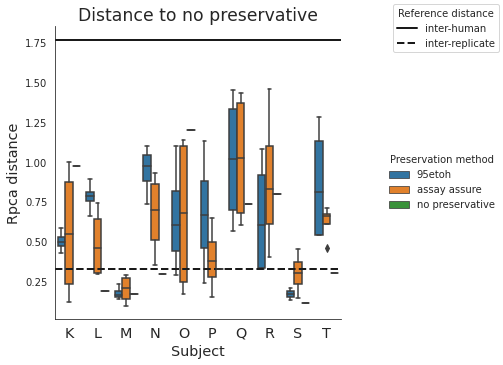

In [13]:
base_val = 'no_preservative'
base_col = 'sample_preservation_method'
id_col = 'host_subject_id'
base_condition = lambda df: (df[base_col] == base_val)

#core diversity metrics @ different sequencing depths
for rf_depth in [38000]:
    core_results = core_metrics_phylogenetic(tree_filtered_table,
                                             rooted_tree,
                                             rf_depth,
                                             q2mf_filtered)
    
    # create metrics, emperor, PERMANOVA, and taxonomy output directories
    core_metric_dir = inputs_dir_name + '/core-metrics-%i'%(rf_depth)
    emperor_dir = output_dir_name + '/emperor-plots-%i'%(rf_depth)
    check_and_create_dir(core_metric_dir)
    check_and_create_dir(emperor_dir)
    perma_dir = output_dir_name + '/permanova-group-plots-%i'%(rf_depth)
    check_and_create_dir(perma_dir)
    box_dir = output_dir_name + '/box-plots-%i'%(rf_depth)
    check_and_create_dir(box_dir)
    
    for name, q2art in zip(core_results._fields, core_results):
#         move emperor plots to output directory
        alpha_dir = emperor_dir if 'emperor' in name else core_metric_dir
        out_ = os.path.join(alpha_dir,name)
        q2art.save(out_)
        
        # create permanova group plot and box plots
        if 'distance' in name:
#             # permanova plot
            distance_metric = name.split('_distance')[0]
            create_perma_groups(q2art, q2mf_filtered, perma_dir, groups, metric_used=distance_metric)
            
            # box plots
            dist_mat = q2art.view(DistanceMatrix)
            test_mat = q2art
            create_box_plot_data(base_condition, groups, base_col, id_col, q2mf_filtered, dist_mat, box_dir,
                                 'Subject', 'value', 'Preservation method', 'groupby',  metric_used=distance_metric)

#make deicode/rpca beta diversity plot
rpcares = rpca(tree_filtered_table)

#makes a directory to put the output in
rpca_dir_name = inputs_dir_name + '/rpca'
check_and_create_dir(rpca_dir_name)
for name, q2art in zip(rpcares._fields, rpcares):
    out_ = os.path.join(rpca_dir_name,name)
    q2art.save(out_)
    
#import biplot made by rpca
bi_plot = q2.Artifact.load(rpca_dir_name + '/biplot.qza')
empbiplt = biplot(bi_plot,q2mf_filtered)

#save rpca visualization
output_rpca_dir = output_dir_name + '/rpca-plots'
check_and_create_dir(output_rpca_dir)
empbiplt.visualization.save(output_rpca_dir + '/empbiplt.qzv')


#beta diversity significance rpca
rpca_perma_dir = output_rpca_dir + '/permanova-group-plots'
check_and_create_dir(rpca_perma_dir)
rpca_dist_matx = q2.Artifact.load(rpca_dir_name + '/distance_matrix.qza')
create_perma_groups(rpca_dist_matx, q2mf_filtered, rpca_perma_dir, groups, metric_used='rpca')

# # box plots
dist_mat = rpca_dist_matx.view(DistanceMatrix)
create_box_plot_data(base_condition, groups, base_col, id_col, q2mf_filtered, dist_mat, output_rpca_dir,
                     'Subject', 'value', 'Preservation method', 'groupby', fname='rpca-box-plot')

# Taxonomy

In [23]:
tax = q2.Artifact.load('taxonomy.qza')
tax_bp = taxa.actions.barplot(tree_filtered_table, tax, q2mf_filtered)
tax_dir_name = output_dir_name + '/taxonomy_plot'
tax_bp.visualization.save(out_)

'inputs/rpca/distance_matrix.qzv'

In [ ]:
distances = dist_mat.data

In [ ]:
dist_mat.data

In [ ]:
dist_mat.ids[0][:-2]